Autoencoder aus __Block 1 - Übung 2__

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [22]:
df_cruise = pd.read_csv("cruise_ship_info.csv")
df_cruise.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [40]:
bins = pd.cut(df_cruise["crew"], bins = 5)

In [41]:
Y = bins
X = df_cruise.drop(columns = ["Ship_name", "Cruise_line", "crew"])
feature_names = df_cruise.drop(columns = ["Ship_name", "Cruise_line"]).columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42)

In [42]:
# Code in Anlehnung an https://machinelearningmastery.com/autoencoder-for-classification/ - nur, dass hier keine Klassifikation vorgenommen wird...

original_dim = 6
latent_dim = 2

def encoder():
    encoder_input=layers.Input(shape=(original_dim,))
    x = layers.Dense(latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.01))(encoder_input)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return Model(encoder_input, [z_mean, z_log_var], name='encoder')

def decoder():
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(original_dim,activation='relu')(decoder_input)
    return Model(decoder_input, x, name='decoder')

def sampling(args):
    z_mean,z_log_var = args
    z_sigma = K.sqrt(K.exp(z_log_var))
    epsilon = K.random_normal(shape=(K.shape(z_mean)),mean=0,stddev=1)
    return z_mean + z_sigma*epsilon

def create_sampler():
    return layers.Lambda(sampling, name='sampler')

encoder = encoder()
decoder = decoder()
sampler = create_sampler()

x = layers.Input(shape=(original_dim,))
z_mean, z_log_var = encoder(x)
z = sampling([z_mean, z_log_var])
z_decoded = decoder(z)
vae = Model(x, z_decoded, name='vae')

rc_loss = keras.losses.mean_squared_error(x,z_decoded)
kl_loss = -0.5 * K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rc_loss+kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='sgd')

vae.fit(x_train, x_train,epochs=100,batch_size=135,validation_data=(x_test,x_test),verbose=0)

x_test_encoded = encoder.predict(x_test)
x_test_decoded = decoder.predict((x_test_encoded[0] + x_test_encoded[1])/2)

print('Ursrpüngliche Beobachtungen:')
print(x_test)
print('Rekonstruierte Beobachtungen:')
print(x_test_encoded)

Ursrpüngliche Beobachtungen:
[[ 3.04302259e-01 -3.46164820e-02 -4.74170674e-02  3.01695050e-01
   3.81401541e-02 -1.17390711e-01]
 [-7.49500633e-01 -8.85080776e-02 -7.93807767e-01 -1.29004548e-01
  -7.47098313e-01  2.67760032e+00]
 [-1.53985280e+00  4.00725319e+00  3.68453643e+00  2.06364795e+00
   4.07650941e+00  9.74299541e-02]
 [ 1.48983051e+00 -1.77666231e+00 -1.74027264e+00 -2.08673000e+00
  -1.81502263e+00 -9.12807769e-01]
 [ 4.25606311e+00 -1.32585911e+00 -1.05711782e+00 -1.31482682e+00
  -1.02754062e+00 -1.52940114e+00]
 [-3.54324549e-01  5.31245272e-01  1.93086602e-01  8.49858175e-01
   2.06405540e-01  5.66551839e-01]
 [-1.40812744e+00  1.17794442e+00  1.79160668e+00  4.86280592e-01
   1.45605647e+00 -8.96551070e-01]
 [-6.17775272e-01  5.48140287e-01  1.32960685e-01  8.44264674e-01
   2.33328002e-01  7.56987456e-01]
 [ 3.04302259e-01 -5.74395727e-02  3.75885401e-02  2.23386032e-01
   6.95496928e-02 -3.67047160e-01]
 [-9.08738254e-02  1.94180287e-01  6.10858064e-01  5.70183111e

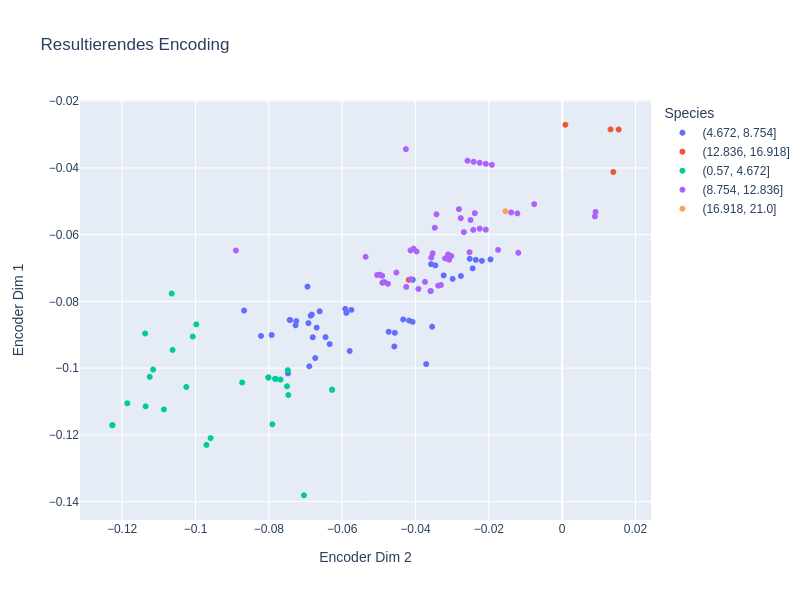

In [43]:
encoded_obs = encoder.predict(x_train)[1]
px.scatter(x = encoded_obs[:,0],y=encoded_obs[:,1],color=y_train,width=800, height=600,title="Resultierendes Encoding",labels={'y': "Encoder Dim 1",'x': "Encoder Dim 2","color": "Species"})

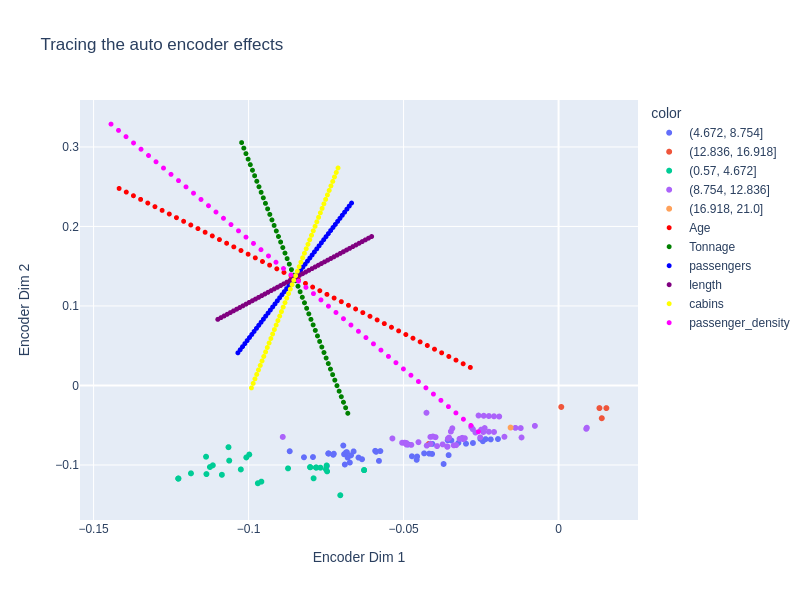

In [44]:
# Darstellung der transformierten Basisvektoren

res = 50

dim_1_mean = np.mean(x_train[:,0])
dim_2_mean = np.mean(x_train[:,1])
dim_3_mean = np.mean(x_train[:,2])
dim_4_mean = np.mean(x_train[:,3])
dim_5_mean = np.mean(x_train[:,4])
dim_6_mean = np.mean(x_train[:,5])


array_1 = encoder.predict(np.array(list(zip(np.array(np.linspace(-5,5,res)),[0]*res,[0]*res,[0]*res,[0]*res,[0]*res))))[0]
array_2 = encoder.predict(np.array(list(zip([0]*res,np.array(np.linspace(-5,5,res)),[0]*res,[0]*res,[0]*res,[0]*res))))[0]
array_3 = encoder.predict(np.array(list(zip([0]*res,[0]*res,np.array(np.linspace(-5,5,res)),[0]*res,[0]*res,[0]*res))))[0]
array_4 = encoder.predict(np.array(list(zip([0]*res,[0]*res,[0]*res,np.array(np.linspace(-5,5,res)),[0]*res,[0]*res))))[0]
array_5 = encoder.predict(np.array(list(zip([0]*res,[0]*res,[0]*res,[0]*res,np.array(np.linspace(-5,5,res)),[0]*res))))[0]
array_6 = encoder.predict(np.array(list(zip([0]*res,[0]*res,[0]*res,[0]*res,[0]*res,np.array(np.linspace(-5,5,res))))))[0]

fig = px.scatter(
    encoded_obs, x=0, y=1, color=y_train,
    title='Tracing the auto encoder effects',
    labels={'0': 'Encoder Dim 1', '1': 'Encoder Dim 2'},width=1000,height=600
)
fig.add_scatter(name=feature_names[0], x=array_1[:,0], y=array_1[:,1], mode='markers',
    marker=dict(size=5, color='red'))
fig.add_scatter(name=feature_names[1], x=array_2[:,0], y=array_2[:,1], mode='markers',
    marker=dict(size=5, color='green'))
fig.add_scatter(name=feature_names[2], x=array_3[:,0], y=array_3[:,1], mode='markers',
    marker=dict(size=5, color='blue'))
fig.add_scatter(name=feature_names[3], x=array_4[:,0], y=array_4[:,1], mode='markers',
    marker=dict(size=5, color='purple'))
fig.add_scatter(name=feature_names[4], x=array_5[:,0], y=array_5[:,1], mode='markers',
    marker=dict(size=5, color='yellow'))
fig.add_scatter(name=feature_names[5], x=array_6[:,0], y=array_6[:,1], mode='markers',
    marker=dict(size=5, color='magenta'))
fig.show()